In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Download and Extract Data

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

--2021-05-25 13:16:29--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2021-05-25 13:16:30--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  30.3MB/s    in 2m 36s  

2021-05-25 13:19:06 (30.5 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



In [ ]:
import tarfile
tar = tarfile.open('/content/food-101.tar.gz')
tar.extractall()

#Data Exploration

In [ ]:
import os

os.listdir('food-101/')

['meta', 'images', 'license_agreement.txt', 'README.txt']

In [ ]:
os.listdir('food-101/meta/')

['train.json',
 'labels.txt',
 'test.txt',
 'test.json',
 'train.txt',
 'classes.txt']

#Splitting Data

In [ ]:
from collections import defaultdict
from shutil import copy

def split_data(filepath, src, dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))

In [ ]:
split_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')
split_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

In [ ]:
path = '/content/food-101/test/apple_pie'
print(f"Test data Apple Pie {len(os.listdir(path))}")

Test data Apple Pie 250


In [ ]:
path = '/content/food-101/train/apple_pie'
print(f"Train data Apple Pie {len(os.listdir(path))}")

Train data Apple Pie 750


In [ ]:
!rm food-101.tar.gz
!rm -rf /content/food-101/images/

#Dataset and Dataloader

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = '/content/food-101/train/'
validation_dir = '/content/food-101/test/'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             label_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  label_mode='categorical',
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 75750 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


Found 75750 files belonging to 101 classes.
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 

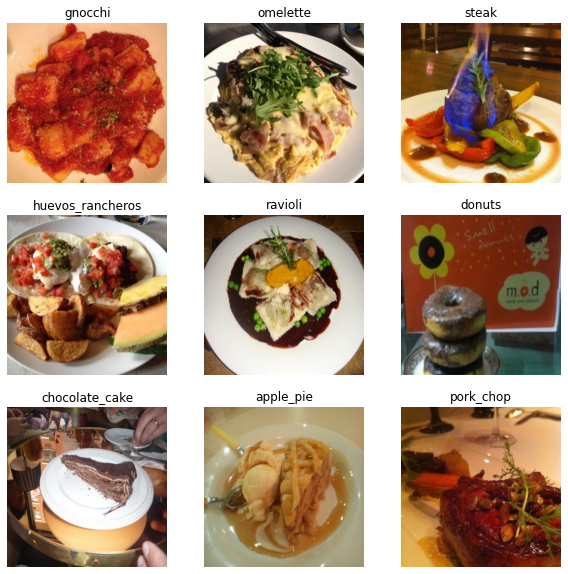

In [ ]:
import matplotlib.pyplot as plt

data = image_dataset_from_directory(train_dir)

class_names = data.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
import tensorflow as tf

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 632
Number of test batches: 158


#Data Preprocessing

In [ ]:
data_augmentation = tf.keras.Sequential([
  # tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

#Architecture

##Load MobileNetV2 Pretrained Model

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


##Freeze Layer

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


##Create New Dense Layer

In [ ]:
from tensorflow.keras import layers

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)

x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  

x = layers.Dense(101, activation='softmax')(x) 

model = tf.keras.Model(inputs, x) 

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              131174

#Training Preparation

In [ ]:
# !rm -r /content/gdrive/MyDrive/training_cp/*

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# # Include the epoch in the file name (uses `str.format`)
# checkpoint_path = "/content/gdrive/MyDrive/training_cp/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

epochs=200

# # Create a callback that saves the model's weights every 5 epochs
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_path, 
#     verbose=1, 
#     save_weights_only=True)

# # Save the weights using the `checkpoint_path` format
# model.save_weights(checkpoint_path.format(epoch=0))

#Training

In [ ]:
# epochs = 2

history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    callbacks=[es_callback])

# history = model.fit(train_dataset,
#                     validation_data=validation_dataset,
#                     steps_per_epoch = 100,
#                     epochs = 2,
#                     validation_steps = 50,
#                     verbose = 2)

Epoch 1/200
2368/2368 [==============================] - 447s 187ms/step - loss: 3.7199 - accuracy: 0.1629 - val_loss: 1.9530 - val_accuracy: 0.5095
Epoch 2/200
2368/2368 [==============================] - 442s 186ms/step - loss: 2.4169 - accuracy: 0.4010 - val_loss: 1.7087 - val_accuracy: 0.5597
Epoch 3/200
2368/2368 [==============================] - 441s 186ms/step - loss: 2.1741 - accuracy: 0.4564 - val_loss: 1.6033 - val_accuracy: 0.5796
Epoch 4/200
2368/2368 [==============================] - 440s 186ms/step - loss: 2.0437 - accuracy: 0.4852 - val_loss: 1.5305 - val_accuracy: 0.5975
Epoch 5/200
2368/2368 [==============================] - 420s 177ms/step - loss: 1.9476 - accuracy: 0.5062 - val_loss: 1.4782 - val_accuracy: 0.6103
Epoch 6/200
2368/2368 [==============================] - 358s 151ms/step - loss: 1.8589 - accuracy: 0.5231 - val_loss: 1.4641 - val_accuracy: 0.6140
Epoch 7/200
2368/2368 [==============================] - 357s 151ms/step - loss: 1.8038 - accuracy: 0.5383

#Plot Loss and Accuracy

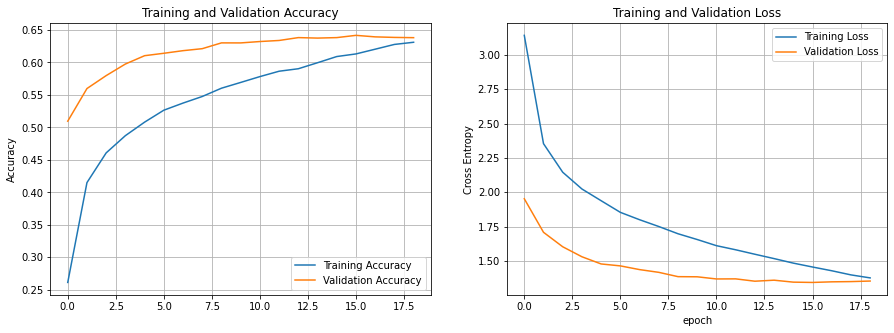

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.grid()
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Fine Tuning

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001/10),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# # Include the epoch in the file name (uses `str.format`)
# checkpoint_path = "/content/gdrive/MyDrive/training_cp/cp_ft-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)


# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_path, 
#     verbose=1, 
#     save_weights_only=True)

# # Save the weights using the `checkpoint_path` format
# model.save_weights(checkpoint_path.format(epoch=0))

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              131174

In [ ]:
len(model.trainable_variables)

62

In [ ]:
fine_tune_epochs = 200
total_epochs =  21 + fine_tune_epochs
print(total_epochs)

221


In [ ]:
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[es_callback])

Epoch 19/221
2368/2368 [==============================] - 390s 162ms/step - loss: 1.3358 - accuracy: 0.6431 - val_loss: 1.2692 - val_accuracy: 0.6615
Epoch 20/221
2368/2368 [==============================] - 384s 162ms/step - loss: 1.2263 - accuracy: 0.6690 - val_loss: 1.2151 - val_accuracy: 0.6780
Epoch 21/221
2368/2368 [==============================] - 384s 162ms/step - loss: 1.1721 - accuracy: 0.6804 - val_loss: 1.1766 - val_accuracy: 0.6857
Epoch 22/221
2368/2368 [==============================] - 384s 162ms/step - loss: 1.1260 - accuracy: 0.6929 - val_loss: 1.1755 - val_accuracy: 0.6837
Epoch 23/221
2368/2368 [==============================] - 384s 162ms/step - loss: 1.0852 - accuracy: 0.7012 - val_loss: 1.1527 - val_accuracy: 0.6897
Epoch 24/221
2368/2368 [==============================] - 384s 162ms/step - loss: 1.0624 - accuracy: 0.7085 - val_loss: 1.1321 - val_accuracy: 0.6964
Epoch 25/221
2368/2368 [==============================] - 383s 162ms/step - loss: 1.0265 - accuracy:

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

NameError: ignored

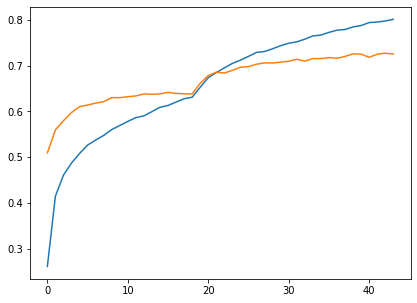

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

In [ ]:
tf.keras.models.save_model(model, '/content/gdrive/MyDrive/saved_model/model.h5')